<a href="https://colab.research.google.com/github/Taghr66d/MSc-SummerProject2025/blob/main/Cusp_Samples_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pycbc

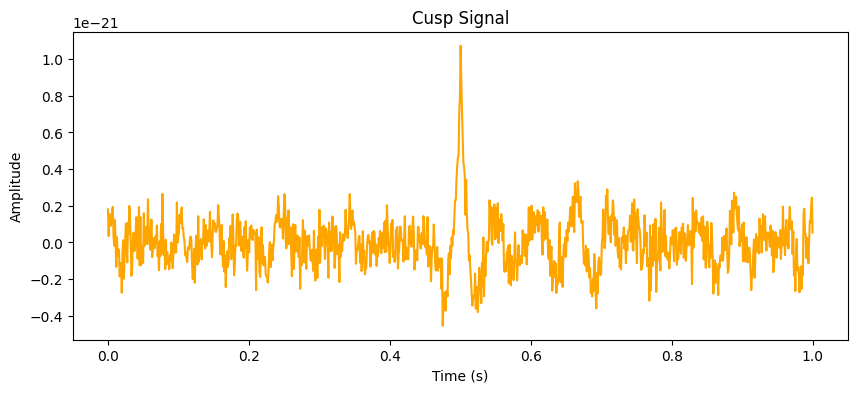

In [23]:
import numpy as np
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.noise import noise_from_psd
from numpy.fft import fft, fftfreq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

###### Configuration:
sample_rate = 1024
delta_t1 = 1 / sample_rate
sig_duration = 0.1
samples = int(sample_rate * sig_duration)
snr_target = 10
num_samples = 10000
sample_rate_noise = 1024
noise_dur = 1.0


##### Cusp signal function:
def cusp_signal(amplitude=9.85e-22, f_high=512, delta_t=1/1024, duration=0.1):
    fs = 1 / delta_t
    N = int(duration * fs)
    freqs = fftfreq(N, d=delta_t)
    h_f = np.zeros(N, dtype=complex)
    pos_mask = freqs > 0
    f_pos = freqs[pos_mask]
    spectrum = f_pos ** (-4/3)
    spectrum[f_pos >= f_high] *= np.exp(1 - f_pos[f_pos >= f_high] / f_high)
    h_f[pos_mask] = amplitude * spectrum
    h_f = h_f + np.conj(h_f[::-1])
    h_f *= np.exp(-2j * np.pi * freqs * (duration / 2))
    h_t = np.fft.ifft(h_f).real
    return h_t

###### Standard SNR computation:
def compute_standard_snr(signal, delta_t, psd, psd_freqs):
    N = len(signal)
    df = 1.0 / (N * delta_t)
    freqs = fftfreq(N, delta_t)
    signal_f = fft(signal)
    mask = freqs > 0
    freqs = freqs[mask]
    signal_f = signal_f[mask]
    psd_interp = interp1d(psd_freqs, psd, bounds_error=False, fill_value="extrapolate")
    psd_vals = psd_interp(freqs)
    psd_vals = np.maximum(psd_vals, 1e-40) #to avoid divide by zero
    snr_squared = 4 * np.sum((np.abs(signal_f) ** 2) / psd_vals) * df ####### eq(3.3)
    return np.sqrt(snr_squared)

### cusp generation:
signal = cusp_signal(delta_t=delta_t1, duration=sig_duration)
#t_signal = np.linspace(0, sig_duration, len(signal))


###### PSD used for noise + SNR computation:
psd = aLIGOZeroDetHighPower(samples // 2 + 1, delta_f=1.0 / sig_duration, low_freq_cutoff=20)
psd_freqs = np.linspace(0, sample_rate / 2, len(psd))
noise_samples = int(noise_dur * sample_rate_noise)
psd_freqs = np.linspace(0, sample_rate_noise / 2, len(psd))
snr_measured = compute_standard_snr(signal, delta_t1, psd, psd_freqs)

scaling = snr_target / snr_measured
signal *= scaling
noise = noise_from_psd(noise_samples, delta_t1, psd, seed=42)


### for plotting--> zero-padded signal
signal_full = np.zeros_like(strain)
signal_full[start:start+len(signal)] = signal
t = np.linspace(0, noise_dur, noise_samples)


plt.figure(figsize=(10, 4))
plt.plot(t, strain, label='Signal', c='orange')
#plt.plot(t, signal_full, label='Noise', c='black')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Cusp Signal')
plt.grid(False)

In [ ]:
###### Dataset generation
X = []
y = []

for i in range(num_samples):
    noise = noise_from_psd(samples, delta_t1, psd)
    inject_signal = (i % 2 == 0)  # alternate: even index = cusp

    if inject_signal:
        snr_target = np.random.uniform(5, 20)
        f_high = np.random.uniform(20, 512)
        signal = cusp_signal(amplitude=9.85e-22, f_high=f_high, delta_t=delta_t1, duration=sig_duration)
        snr_measured = compute_standard_snr(signal, delta_t1, psd, psd_freqs)
        signal *= snr_target / snr_measured
        start = (samples - len(signal)) // 2
        noise[start:start + len(signal)] += signal
        label = 1
    else:
        label = 0

    ### Normalize strain
    strain = (noise - np.mean(noise)) / np.std(noise)
    X.append(strain)
    y.append(label)

##### Finalize
X = np.array(X)
y = np.array(y)

In [ ]:
print("X shape:", X.shape)  # (10000, 1024)
print("y shape:", y.shape)

In [ ]:
##### Saving
np.save("X_cusp_dataset10k.npy", X)
np.save("y_cusp_labels10k.npy", y)
